In [1]:
import random
from typing import List, Tuple

import medical_image_segmentation.analyze_data.utils as utils
import medical_image_segmentation.analyze_data.create_ffcv_subset as subset
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from collections import Counter, defaultdict

from PIL import Image

import json

In [2]:
mpl.rc('image', cmap='cool')

In [3]:
def get_discrete_colors(n: int, solid=False) -> List[Tuple[float, float, float, float]]:
    """
    Gets the discrete colors for all plots.
    
    Parameters
    ----------
    n : int The number of items to get colors for.
    solid : bool [default: False] If True, all colors are the same. Otherwise, returns a discrete sampling over a gradient.

    Returns
    -------
    List[Tuple[float, float, float, float]]
        List of tuples of RGBA colors.
    """
    if solid:
        return [mpl.colors.to_rgba("darkorchid") for x in range(n)]
    else:
        cmap = mpl.colormaps["cool"]
        return cmap(np.linspace(0, 1, n))

In [4]:
def plot_image_shapes(image_shapes: List[List[int]]):
    """
    Plot image sizes on a scatter plot, with more frequent sizes represented by larger points.

    Parameters
    ----------
    image_shapes : List[List[int]] List of width, height pairs.
    """
    shape_counter = Counter(tuple(shape) for shape in image_shapes)
    widths, heights, counts = zip(*[(shape[0], shape[1], count) for shape, count in shape_counter.items()])

    widths = np.array(widths)
    heights = np.array(heights)
    counts = np.array(counts)
    
    max_size = 10_000
    min_size = 1
    point_sizes = np.clip(counts / np.max(counts) * max_size, min_size, max_size)

    plt.figure(figsize=(10, 6))
    plt.scatter(widths, heights, s=point_sizes, c=np.sqrt(widths * heights), alpha=0.8)
    plt.colorbar(label="Sqrt of Area (pixels^2)")
    plt.title("Distribution of DICOM Image Dimensions")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.tight_layout()

    plt.show()

In [5]:
def plot_dataset_counts(dataset_dict: dict[str, int]):
    """
    Plot the number of images in each dataset.

    Parameters
    ----------
    dataset_dict : dict[str, int]
        A dictionary where the keys are the name of the dataset and the value is the number of images in that dataset.
    """
    names = sorted(list(dataset_dict.keys()))
    counts = []
    for dataset_name in names:
        counts.append(dataset_dict[dataset_name])
    n = len(counts)
    
    plt.figure(figsize=(10, 6))
    plt.bar(names, counts, color=get_discrete_colors(n, solid=True))
    plt.title("Distribution of DICOM Images in Each Dataset")
    plt.xlabel("Dataset")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Frequency")
    plt.tight_layout()

    plt.show()

In [6]:
images_root_dir = "/scratch/gpfs/eh0560/data/med_datasets/radiology_1M"
dimensions_path = "/scratch/gpfs/eh0560/repos/medical-image-segmentation/data/subset_info/image_dimensions.json"
original_to_new_map_path = "/scratch/gpfs/eh0560/repos/medical-image-segmentation/data/subset_info/original_to_new_map.json"

In [7]:
image_paths = utils.get_file_paths(images_root_dir, lambda path: path.endswith(".png"))
print(len(image_paths))

1000000


In [8]:
with open(dimensions_path, "r") as f:
        dimensions = json.load(f)
        subset_dimensions = {}
        for file_path in image_paths:
            subset_dimensions[file_path] = dimensions[file_path]

if len(subset_dimensions) != len(image_paths):
    raise ValueError(f"subset_dimensions has length different than files. Length of files is {len(image_paths)}, and length of subset_dimensions is {len(subset_dimensions)}")

In [9]:
with open(original_to_new_map_path, "r") as f:
    original_to_new_map = json.load(f)

new_to_original_path = {}
for original_path, new_path in original_to_new_map.items():
    new_to_original_path[new_path] = original_path

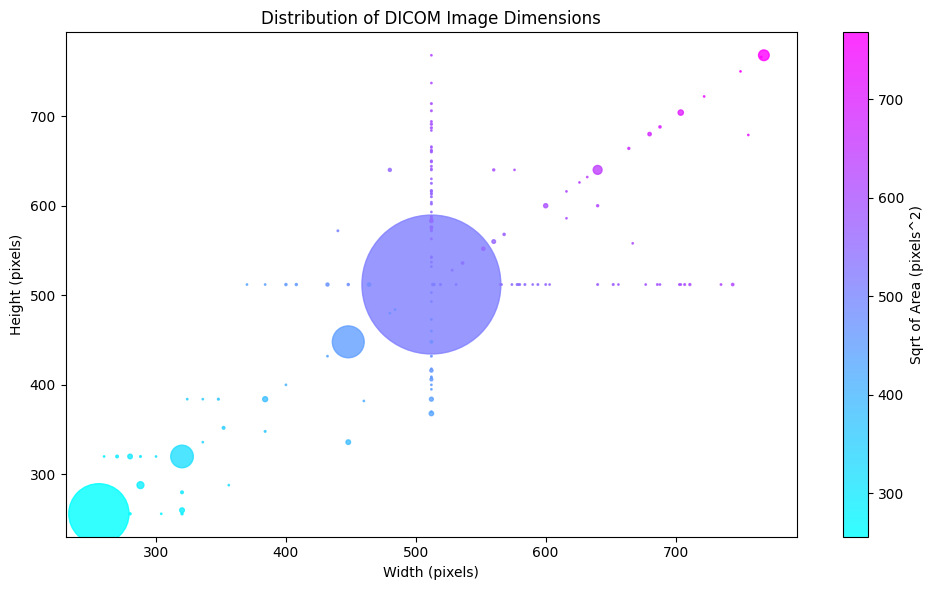

In [10]:
plot_image_shapes(list(subset_dimensions.values()))

In [11]:
dataset_counts = defaultdict(int)
for file_path in image_paths:
    original_path = new_to_original_path[file_path]
    dataset_name = original_path.split("med_datasets/")[1].split("/")[0]
    dataset_counts[dataset_name] += 1

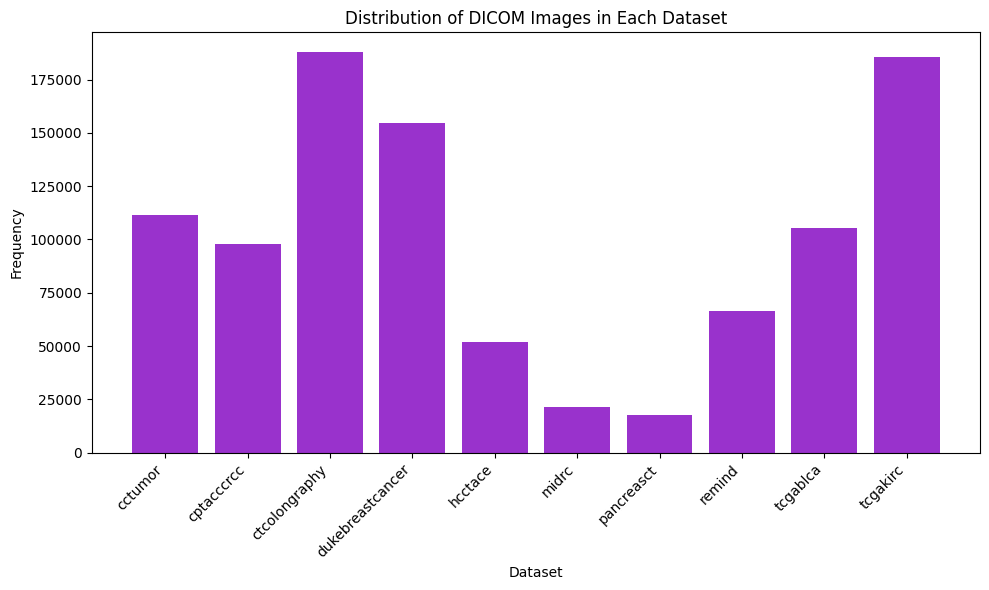

In [12]:
plot_dataset_counts(dataset_counts)

In [13]:
image_paths = subset.get_image_paths(original_to_new_map_path)
dataset = subset.DICOMImageDataset(image_paths, (256, 256))

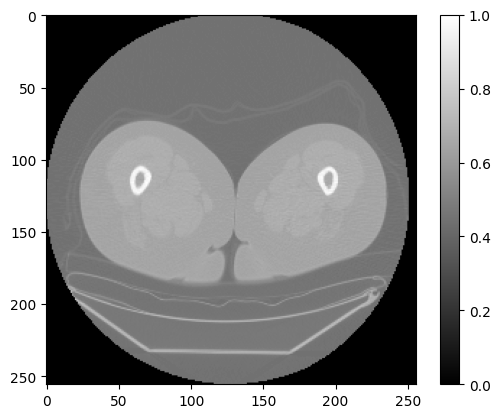

In [55]:
idx = random.randint(0, len(dataset) - 1)
im = dataset.__getitem__(idx)
plt.imshow(im, cmap="gray", vmin=0, vmax=1)
plt.colorbar()
plt.show()